In [1]:
!python --version

Python 3.7.16


In [1]:
from Agent import Agent
#from NegotiationNet import NegotiationNet

import torch

import numpy as np

import os
os.chdir("..")
from rice import Rice

import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
envs_2_regions = [Rice(region_yamls_filename='2_region_yamls/') for _ in range(5)]
initial_state_2 = envs_2_regions[0].reset()

envs_4_regions = [Rice(region_yamls_filename='identical_region_yamls/') for _ in range(5)]
initial_state_4 = envs_4_regions[0].reset()

In [3]:
agents_2 = [Agent(envs_2_regions[0], initial_state_2[agent_id], agent_id) 
            for agent_id in range(envs_2_regions[0].num_agents)]
agents_4 = [Agent(envs_4_regions[0], initial_state_4[agent_id], agent_id) 
            for agent_id in range(envs_4_regions[0].num_agents)]

In [2]:
envs = [Rice(region_yamls_filename='2_region_yamls/') for _ in range(5)]
initial_state = envs[0].reset()
agents = [Agent(envs[0], initial_state[agent_id], agent_id) 
            for agent_id in range(envs[0].num_agents)]

In [3]:
rs_difference = {agent.id : [] for agent in agents}
rs_negotiation = {agent.id : [] for agent in agents}

episode_length = envs[0].episode_length

for epoch in tqdm(range(50)):
    for batch in range(2):
        states = [env.reset() for env in envs]
        for t in range(envs[0].episode_length):
            collective_action = {}
            
            # Do negotiation for proposals
            for agent in agents:
                collective_action[agent.id] = agent.negotiate(
                    [state[agent.id] for state in states],
                    save_map = {
                        'save_state' : True,
                        'save_decisions' : False,
                        'save_proposals_promises' : True
                    }
                )
            
            # Register proposals
            for env_id in range(len(envs)):
                envs[env_id].register_proposals({
                    agent_id: {
                        identifier: action[env_id]
                        for identifier, action in action_dict.items()
                    }
                    for agent_id, action_dict in collective_action.items()
                })
            
            # Do negotiation for decisions
            for agent in agents:
                collective_action[agent.id] = agent.negotiate(
                    [state[agent.id] for state in states],
                    save_map = {
                        'save_state' : False,
                        'save_decisions' : True,
                        'save_proposals_promises' : False
                    }
                )
                
            # Register decisions
            for env_id in range(len(envs)):
                envs[env_id].register_decisions({
                    agent_id: {
                        identifier: action[env_id]
                        for identifier, action in action_dict.items()
                    }
                    for agent_id, action_dict in collective_action.items()
                })
            
            # Update action masks from negotiation
            for env in envs:
                env.update_masks()
       
            # Act in the encironemnt without masks
            for agent in agents:
                collective_action[agent.id] = agent.act(
                    [state[agent.id] for state in states],
                    with_mask = False
                )
            
            # Obtain rewards
            states, rewards_no_negotiation, _, _ = zip(*[
                env.step({agent_id : collective_action[agent_id][i] 
                        for agent_id in range(len(agents))}) 
                for (i, env) in enumerate(envs)
            ])
            
            # Rollback environments 1 step
            states = [env.rollback() for env in envs]
            
            # Act with negotiated masks
            collective_action = {}
            for agent in agents:
                collective_action[agent.id] = agent.act(
                    [state[agent.id] for state in states],
                )
            
            # Obtain rewards and new states
            states, rewards_negotiation, _, _ = zip(*[
                env.step({agent_id : collective_action[agent_id][i] 
                        for agent_id in range(len(agents))}) 
                for (i, env) in enumerate(envs)
            ])
            
            # Rewards with negotiation - rewards without negotiation
            for (env_id, d) in enumerate(rewards_negotiation):
                for agent_id in d:
                    rewards_no_negotiation[env_id][agent_id] = \
                        -rewards_no_negotiation[env_id][agent_id] + \
                        rewards_negotiation[env_id][agent_id]
            
            # Register rewards into agents' buffers
            for agent in agents:
                r_difference = [reward[agent.id] for reward in rewards_no_negotiation]
                rs_difference[agent.id].append(r_difference)
                
                r_negotiation = [reward[agent.id] for reward in rewards_negotiation]
                rs_negotiation[agent.id].append(r_negotiation)
                
                agent.nets['negotiationNet'].buffer.rewards.extend(r_difference)
                agent.nets['negotiationNet'].buffer.is_terminals.extend([t == episode_length - 1] * len(envs))
                
                agent.nets['activityNet'].buffer.rewards.extend(r_negotiation)
                agent.nets['activityNet'].buffer.is_terminals.extend([t == episode_length - 1] * len(envs))
                
    for agent in agents:
        agent.update()

 20%|████████████████                                                                | 10/50 [00:24<01:39,  2.49s/it]


KeyboardInterrupt: 

In [5]:
rss_diff = {k: np.array(rs_difference[k]).mean(axis=1) for k in rs_difference}
rss_nego = {k: np.array(rs_negotiation[k]).mean(axis=1) for k in rs_negotiation}

In [4]:
# Cell without any negotiation

rs = {agent.id : [] for agent in agents}

episode_length = envs[0].episode_length

for epoch in range(50):
    for batch in range(10):
        states = [env.reset() for env in envs]
        for t in range(envs[0].episode_length):
            
            collective_action = {}
            for agent in agents:
                collective_action[agent.id] = agent.act(
                    [state[agent.id] for state in states],
                )
            
            # Obtain rewards and new states
            states, rewards, _, _ = zip(*[
                env.step({agent_id : collective_action[agent_id][i] 
                        for agent_id in range(len(agents))}) 
                for (i, env) in enumerate(envs)
            ])
            
            # Register rewards into agents' buffers
            for agent in agents:
                r = [reward[agent.id] for reward in rewards]
                rs[agent.id].append(r)
                
                agent.nets['activityNet'].buffer.rewards.extend(r)
                agent.nets['activityNet'].buffer.is_terminals.extend([t == episode_length - 1] * len(envs))
                
    if epoch % 10 == 0:
        print(f"Epoch: {epoch}")
    for agent in agents:
        agent.nets['activityNet'].update()

Epoch: 0


KeyboardInterrupt: 

In [6]:
def run_one_batch(agents, envs):
    episode_length = envs[0].episode_length
    states = [env.reset() for env in envs]
    for t in range(envs[0].episode_length):
        collective_action = {}

        # Do negotiation for proposals
        for agent in agents:
            collective_action[agent.id] = agent.negotiate(
                [state[agent.id] for state in states],
                save_map = {
                    'save_state' : True,
                    'save_decisions' : False,
                    'save_proposals_promises' : True
                }
            )

        # Register proposals
        for env_id in range(len(envs)):
            envs[env_id].register_proposals({
                agent_id: {
                    identifier: action[env_id]
                    for identifier, action in action_dict.items()
                }
                for agent_id, action_dict in collective_action.items()
            })

        # Do negotiation for decisions
        for agent in agents:
            collective_action[agent.id] = agent.negotiate(
                [state[agent.id] for state in states],
                save_map = {
                    'save_state' : False,
                    'save_decisions' : True,
                    'save_proposals_promises' : False
                }
            )

        # Register decisions
        for env_id in range(len(envs)):
            envs[env_id].register_decisions({
                agent_id: {
                    identifier: action[env_id]
                    for identifier, action in action_dict.items()
                }
                for agent_id, action_dict in collective_action.items()
            })

        # Update action masks from negotiation
        for env in envs:
            env.update_masks()

        # Act in the encironemnt without masks
        for agent in agents:
            collective_action[agent.id] = agent.act(
                [state[agent.id] for state in states],
                with_mask = False
            )

        # Obtain rewards
        states, rewards_no_negotiation, _, _ = zip(*[
            env.step({agent_id : collective_action[agent_id][i] 
                    for agent_id in range(len(agents))}) 
            for (i, env) in enumerate(envs)
        ])

        # Rollback environments 1 step
        states = [env.rollback() for env in envs]

        # Act with negotiated masks
        collective_action = {}
        for agent in agents:
            collective_action[agent.id] = agent.act(
                [state[agent.id] for state in states],
            )

        # Obtain rewards and new states
        states, rewards_negotiation, _, _ = zip(*[
            env.step({agent_id : collective_action[agent_id][i] 
                    for agent_id in range(len(agents))}) 
            for (i, env) in enumerate(envs)
        ])

        # Rewards with negotiation - rewards without negotiation
        for (env_id, d) in enumerate(rewards_negotiation):
            for agent_id in d:
                rewards_no_negotiation[env_id][agent_id] = \
                    -rewards_no_negotiation[env_id][agent_id] + \
                    rewards_negotiation[env_id][agent_id]

        # Register rewards into agents' buffers
        for agent in agents:
            r_difference = [reward[agent.id] for reward in rewards_no_negotiation]

            r_negotiation = [reward[agent.id] for reward in rewards_negotiation]

            agent.nets['negotiationNet'].buffer.rewards.extend(r_difference)
            agent.nets['negotiationNet'].buffer.is_terminals.extend([t == episode_length - 1] * len(envs))

            agent.nets['activityNet'].buffer.rewards.extend(r_negotiation)
            agent.nets['activityNet'].buffer.is_terminals.extend([t == episode_length - 1] * len(envs))


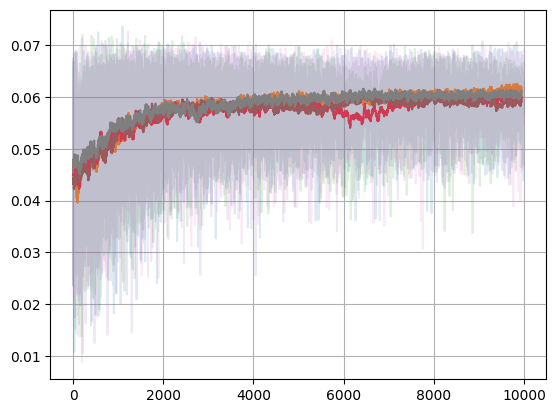

In [6]:
#rs = {k: np.array(rs[k]).mean(axis=1) for k in rs}
for r in rs:
    plt.plot(rs[r], alpha = .15)
    plt.plot(np.convolve(rs[r], np.ones(50)/50, mode = 'valid'))
plt.grid()
plt.show()

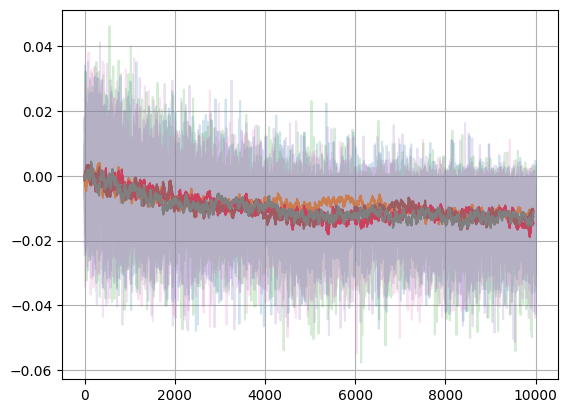

In [6]:
for r in rss_diff:
    plt.plot(rss_diff[r], alpha = .2)
    plt.plot(np.convolve(rss_diff[r], np.ones(50)/50, mode='valid'))

plt.grid()
plt.show()

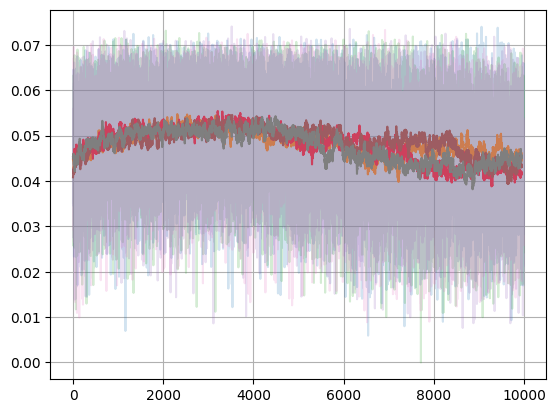

In [7]:
for r in rss_nego:
    plt.plot(rss_nego[r], alpha = .2)
    plt.plot(np.convolve(rss_nego[r], np.ones(50)/50, mode='valid'))

plt.grid()
plt.show()